### Random forest and decision tree

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\yolan\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data_dummis = pd.read_pickle('Data/data_dummis_dataframe_with_events.pkl')

In [3]:
data_dummis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 2016-10-30 to 2017-04-09
Freq: D
Data columns (total 10 columns):
Item                 162 non-null int64
is_local_event       162 non-null int32
is_bank_holiday      162 non-null int32
Date                 162 non-null datetime64[ns]
Week_Day_Friday      162 non-null uint8
Week_Day_Monday      162 non-null uint8
Week_Day_Saturday    162 non-null uint8
Week_Day_Sunday      162 non-null uint8
Week_Day_Thursday    162 non-null uint8
Week_Day_Tuesday     162 non-null uint8
dtypes: datetime64[ns](1), int32(2), int64(1), uint8(6)
memory usage: 6.0 KB


In [4]:
X = data_dummis[['Week_Day_Friday', 'Week_Day_Monday',
       'Week_Day_Saturday', 'Week_Day_Sunday', 'Week_Day_Thursday',
       'Week_Day_Tuesday','is_local_event', 'is_bank_holiday']]
y = data_dummis['Item']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

129 33
129 33


### Used a grid search to tuned the decision tree regressor
- Need to have in mind that when tuning a decision tree we can create an over fitter model

In [5]:
estimator = DecisionTreeRegressor()

grid = GridSearchCV(estimator,
                    param_grid={'max_depth': range(1,10,1), 'min_samples_leaf': range(1,10,1)},
                    scoring='neg_mean_squared_error',
                    return_train_score=True,
                    cv=5, 
                   iid=True)

grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 10), 'min_samples_leaf': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [6]:
grid.best_params_

{'max_depth': 4, 'min_samples_leaf': 1}

In [7]:
grid.best_score_

-906.8070547455633

In [8]:
dt_tuned = DecisionTreeRegressor(max_depth=4)
dt_tuned.fit(X_train, y_train)
export_graphviz(dt_tuned, 'Data/Bakery_dt_tuned.dot', feature_names=X.columns)

In [9]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
export_graphviz(dt, 'Data/Bakery.dot', feature_names=X.columns)

In [10]:
dt_half_tuned = DecisionTreeRegressor(max_depth=3)
dt_half_tuned.fit(X_train, y_train)
export_graphviz(dt_half_tuned, 'Data/Bakery_dt_half_tuned.dot', feature_names=X.columns)

In [11]:
!dot -Tpng Data/bakery.dot -o Data/bakery.png

In [12]:
!dot -Tpng Data/bakery_dt_tuned.dot -o Data/bakery_dt_tuned.png

In [13]:
!dot -Tpng Data/Bakery_dt_half_tuned.dot -o Data/Bakery_dt_half_tuned.png

In [14]:
# Compute the feature importances (the Gini index at each node).
dt_feature_importances = pd.DataFrame({'feature':X.columns, 'DT':dt.feature_importances_, 'DT_Tuned':dt_tuned.feature_importances_,'DT_half_Tuned':dt_half_tuned.feature_importances_}).sort_values(by='DT', ascending=False)
dt_feature_importances

,feature,DT,DT_Tuned,DT_half_Tuned
2,Week_Day_Saturday,0.619771,0.626299,0.679531
7,is_bank_holiday,0.210117,0.212330,0.230377
0,Week_Day_Friday,0.058681,0.059299,0.000000
3,Week_Day_Sunday,0.054205,0.054776,0.059432
6,is_local_event,0.046885,0.047296,0.030659
4,Week_Day_Thursday,0.006439,0.000000,0.000000
1,Week_Day_Monday,0.003895,0.000000,0.000000
5,Week_Day_Tuesday,0.000007,0.000000,0.000000


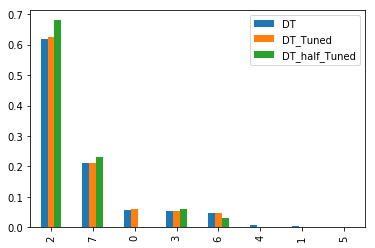

In [15]:
dt_feature_importances.plot.bar()

### Let's also fit a model with Random Forest and compare

In [16]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_train)

### Find the best parametors for the random forest

In [17]:
rf_grid = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid={"n_estimators": [1, 3, 5, 7 ,9, 10, 11, 13, 15, 17, 19, 21],
                                "min_samples_split": [2, 5, 10],
                                "min_samples_leaf": [1, 5, 10, 25],
                                "max_depth": [1, 3, 5, 7, 10, None],
                                #"max_features": [0, 10],
                                "bootstrap": [True, False]},
                    scoring="neg_mean_squared_error",
                    cv=5)

rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10, 25], 'max_depth': [1, 3, 5, 7, 10, None], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [18]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 17}

In [19]:
rf_tuned = RandomForestRegressor(bootstrap=True,max_depth=5,min_samples_leaf=1,min_samples_split=5,n_estimators=17)
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [20]:
y_pred_rf_tuned = rf_tuned.predict(X_train)
y_pred_dt = dt.predict(X_train)
y_pred_dt_tuned = dt_tuned.predict(X_train)

### Get the RMSE and scores for all model

In [21]:
#Get the RMSE and score of all models in a dataframe
RMSE_SCORES_results = pd.DataFrame(columns=['Model', 'Train_RMSE', 'Test_RMSE', 'Train_Score','Test_Score'], index=range(5))
model_list = [dt,dt_tuned,dt_half_tuned,rf,rf_tuned]
y_pred_mean_train = [y_train.mean()] * len(y_train)
y_pred_mean_test = [y_test.mean()] * len(y_test)

for i, item in enumerate(model_list):
    rmse_train = np.sqrt(mean_squared_error(y_train, item.predict(X_train)))
    rmse_test = np.sqrt(mean_squared_error(y_test, item.predict(X_test)))
    score_train = item.score(X_train, y_train)
    score_test = item.score(X_test, y_test)
    item_str = str(item)
    item_name = item_str[:16]
    if i == 1 or i == 4:
        item_name = item_name + '_Tuned'
    elif i == 2:
        item_name = item_name + '_half_Tuned'

    RMSE_SCORES_results.loc[i] = [item_name, rmse_train, rmse_test, score_train,score_test]

RMSE_SCORES_results.loc[5] = ['Baseline',  np.sqrt(metrics.mean_squared_error(y_train, y_pred_mean_train)), np.sqrt(metrics.mean_squared_error(y_test, y_pred_mean_test)),0.0, 0.0]

RMSE_SCORES_results.index = RMSE_SCORES_results.Model

In [22]:
RMSE_SCORES_results

,Model,Train_RMSE,Test_RMSE,Train_Score,Test_Score
Model,,,,,
DecisionTreeRegr,DecisionTreeRegr,28.4897,25.0507,0.644892,0.723409
DecisionTreeRegr_Tuned,DecisionTreeRegr_Tuned,28.758,25.2933,0.638171,0.718026
DecisionTreeRegr_half_Tuned,DecisionTreeRegr_half_Tuned,30.6805,27.1116,0.588178,0.676026
RandomForestRegr,RandomForestRegr,28.8474,26.4471,0.635918,0.691713
RandomForestRegr_Tuned,RandomForestRegr_Tuned,28.6974,25.6866,0.639695,0.709188
Baseline,Baseline,47.8088,47.6322,0,0


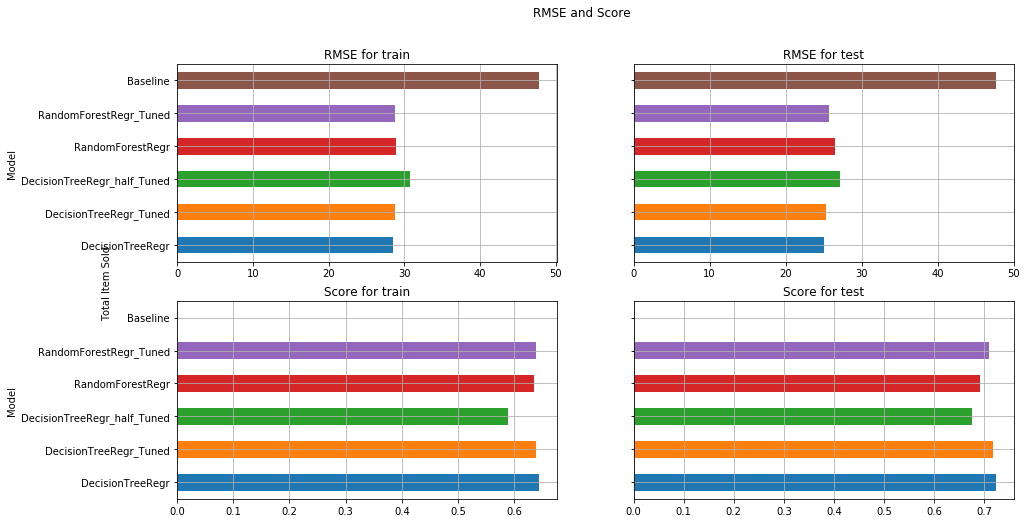

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(15,8), sharex=False, sharey=True, squeeze=False)

fig.suptitle('RMSE and Score', fontsize=12)
fig.text(0.06, 0.5, 'Total Item Sold', ha='center', va='center', rotation='vertical', )
#fig.text(0.5, 0.04, 'Hours', ha='center', va='center', rotation=45)

RMSE_train_graph = RMSE_SCORES_results['Train_RMSE']
RMSE_train_graph.plot(ax=axes[0][0], grid=True, kind='barh', title='RMSE for train')

RMSE_test_graph = RMSE_SCORES_results['Test_RMSE']
RMSE_test_graph.plot(ax=axes[0][1], grid=True, kind='barh', title='RMSE for test')

score_train_graph = RMSE_SCORES_results['Train_Score']
score_train_graph.plot(ax=axes[1][0], grid=True, kind='barh', title='Score for train')

score_test_graph = RMSE_SCORES_results['Test_Score']
score_test_graph.plot(ax=axes[1][1], grid=True, kind='barh', title='Score for test')


### Let run cross validation
- All models have a little of a variance problem

In [24]:
def cross_validation_test(model_name, x_data, y_data, scoring_name, n):
    cv_scores = cross_val_score(model_name, x_data, y_data, scoring=scoring_name, cv=n)
    return np.sqrt(-cv_scores), np.sqrt(-cv_scores.mean())

In [27]:
RMSE_SCORES_results = pd.DataFrame(columns=['Model', 'RMSE', 'Average RMSE'], index=range(2))
model_list = [dt,dt_half_tuned, dt_tuned,rf,rf_tuned]
          
for item in model_list:
    model_string = str(item)
    print('Results for ' + model_string[:10])
    print(cross_validation_test(item,  X, y, 'neg_mean_squared_error', 5))

Results for DecisionTr
(array([43.03603975, 54.75396975, 27.3901359 , 22.72267289, 24.46536595]), 36.64748684650513)
Results for DecisionTr
(array([45.87477546, 54.71350902, 29.1251675 , 25.61239818, 25.09734761]), 38.03211872213115)
Results for DecisionTr
(array([43.40969428, 54.32269408, 27.04818498, 22.82678524, 24.17536603]), 36.53073064325489)
Results for RandomFore
(array([42.88622088, 54.43834369, 27.43946781, 22.62539183, 24.5934413 ]), 36.530620875825086)
Results for RandomFore
(array([43.57588035, 54.30639338, 27.3233892 , 23.55990519, 23.47418058]), 36.60796523614586)


### Look at the results in graphs

In [30]:
results_dt_rf_pred_train = pd.DataFrame({'Actual': y_train, 'DT_Pred': y_pred_dt,'DT_Tuned_Pred': y_pred_dt_tuned,'RF_Pred': y_pred_rf, 'RF_Tuned_Pred': y_pred_rf_tuned})

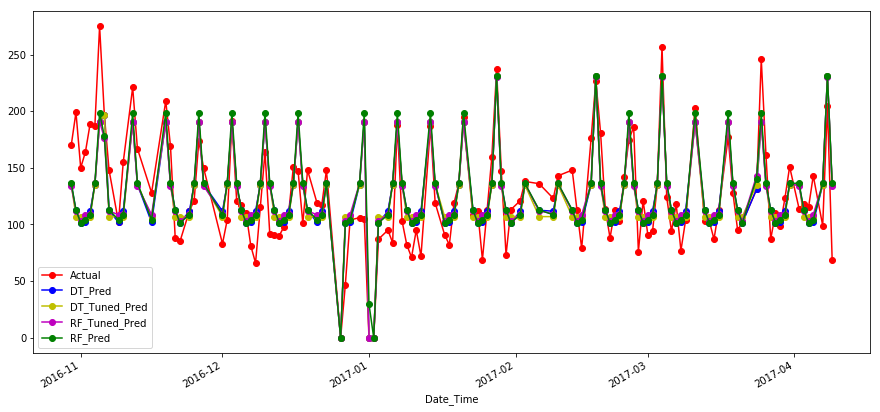

In [31]:
results_dt_rf_pred_train[['Actual', 'DT_Pred', 'DT_Tuned_Pred','RF_Tuned_Pred', 'RF_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'DT_Pred': '-ob','DT_Tuned_Pred': '-oy','RF_Pred': '-og', 'RF_Tuned_Pred': '-om'})

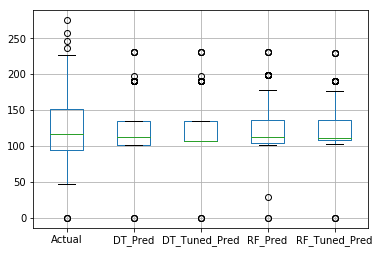

In [32]:
results_dt_rf_pred_train.boxplot()

In [33]:
results_dt_rf_pred_test = pd.DataFrame({'Actual': y_test, 'DT_Pred': dt.predict(X_test),'DT_Tuned_Pred': dt_tuned.predict(X_test), 'RF_Pred': rf.predict(X_test), 'RF_Tuned_Pred': rf_tuned.predict(X_test)})

In [34]:
results_dt_rf_pred_test.describe()

,Actual,DT_Pred,DT_Tuned_Pred,RF_Pred,RF_Tuned_Pred
count,33.000000,33.000000,33.000000,33.000000,33.000000
mean,127.333333,122.254347,122.754876,124.134852,123.268931
std,48.370747,38.671593,38.226541,37.451924,38.023849
min,0.000000,0.000000,0.000000,29.720551,0.000000
25%,103.000000,101.823529,106.957746,104.112178,108.581770
50%,123.000000,111.777778,106.957746,108.561134,109.454551
75%,149.000000,135.058824,134.833333,136.176486,136.222083
max,292.000000,231.500000,231.500000,230.937778,230.046606


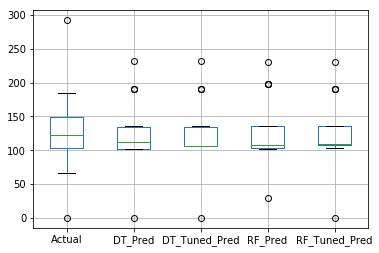

In [35]:
results_dt_rf_pred_test.boxplot()

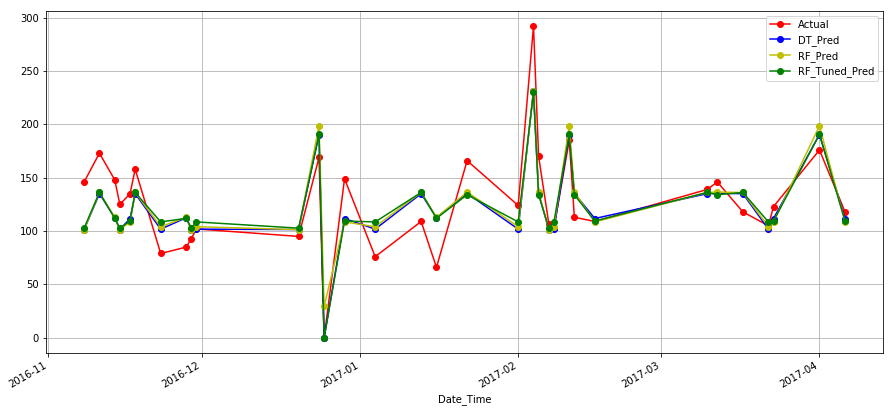

In [36]:
results_dt_rf_pred_test[['Actual', 'DT_Pred', 'RF_Pred', 'RF_Tuned_Pred']].plot(figsize=(15,7), style={'Actual': '-or', 'DT_Pred': '-ob', 'RF_Pred': '-oy', 'RF_Tuned_Pred': '-og'}, grid=True)

In [37]:
results_dt_rf_pred_train.to_pickle('Data/results_dt_rf_pred_train.pkl')

In [38]:
results_dt_rf_pred_test.to_pickle('Data/results_dt_rf_pred_test.pkl')

### Conclusion
- The results for all the models are very similar
- The decision tress and random forest tuned are able to predict correctly bank holidays
- All models underestimates days with really high sales
- In general results are very similar to the linear regression models